In this notebook we are going to generate the physiological regressors for one subject from eBACH and compute their statistical maps.

In [1]:
import numpy as np
from nilearn.image import load_img
import sys
sys.path.append("../code")

from nilearn import plotting
from nilearn.image import math_img

from nilearn.glm.first_level import FirstLevelModel
from regressors import RetroicorPhysio, RVPhysio, HVPhysio, DownsamplePhysio

/home/javi/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
bold_img = load_img("../data/ebach/sub-E1058/ses-01/func/sub-E1058_ses-01_task-rest_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
confounders = pd.read_csv("../data/ebach/sub-E1058/ses-01/func/sub-E1058_ses-01_task-rest_acq-mb3_desc-confounds_regressors.tsv", 
                    sep="\t")
motion = confounders.filter(regex="(trans|rot)_(x|y|z)")
n_samples = bold_img.shape[-1]
repetition_time = 2.0
frame_times = np.arange(n_samples)*repetition_time

## Loading LOG files

In [3]:
from input_data import load_cmrr_info, load_cmrr_data
# So the second column to the respiratary signal, and the third one corresponds to ECG
info_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_Info.log"
ecg_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_ECG.log"
resp_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_RESP.log"
puls_log = "../data/ebach/sub-E1058/func-bold_task-rest_acq-mb3_PhysioLog/Physio_20191016_110935_034823c3-2e93-419c-b822-2bf382f43207_PULS.log"

scan_traces, info_dict = load_cmrr_info(info_log)

print(info_dict)

ecg_signal,_ = load_cmrr_data(ecg_log, info_dict)
print(ecg_signal)

resp_signal,_ = load_cmrr_data(resp_log, info_dict)
print(resp_signal)

puls_signal,_ = load_cmrr_data(puls_log, info_dict)
print(puls_signal)


assert ecg_signal.shape[0] == resp_signal.shape[0]
assert ecg_signal.shape[0] == puls_signal.shape[0]

print(f"length of acquisition (should be ~ {info_dict['n_vols']*repetition_time}) =  {puls_signal.shape[0]/400}")

{'uuid': '034823c3-2e93-419c-b822-2bf382f43207', 'scan_date': '20191016_110935', 'log_version': 'EJA_1', 'n_slices': 69, 'n_vols': 240, 'n_echoes': 1, 'init_physio': 16086454, 'end_physio': 16282473, 'init_scan': 16090485, 'end_scan': 16282463, 'repetition_time': 800.0}
[[1815. 1858. 1979. 1980.]
 [2020. 1983. 1908. 1944.]
 [2188. 2061. 1910. 1966.]
 ...
 [2023. 2014. 1981. 2007.]
 [2020. 2011. 1983. 2008.]
 [2015. 2009. 1984. 2010.]]
[[356. ]
 [356. ]
 [356. ]
 ...
 [461. ]
 [459.5]
 [458. ]]
[[2983.]
 [3000.]
 [3017.]
 ...
 [2642.]
 [2627.]
 [2612.]]
length of acquisition (should be ~ 480.0) =  479.9475


# Retroicor regressors

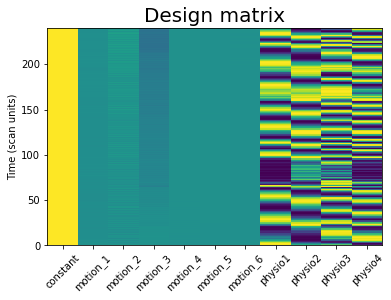

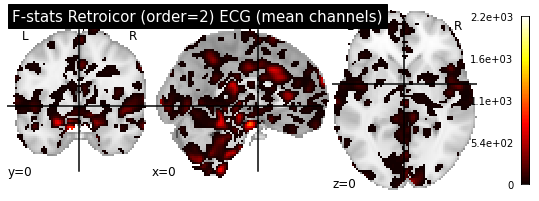

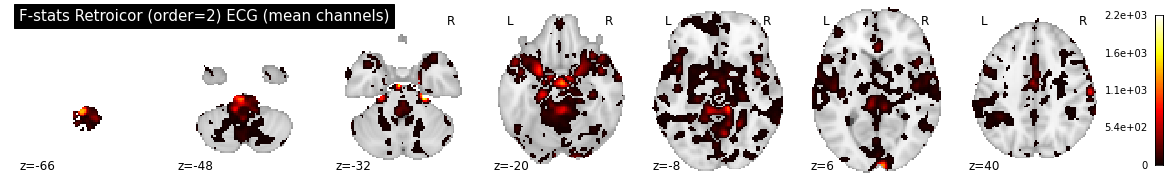

In [4]:
retro_ecg = RetroicorPhysio(physio_rate=400, 
                            t_r=repetition_time, 
                            delta=200, 
                            filtering="butter", 
                            high_pass=0.5, 
                            low_pass=3.0, 
                            order=2, 
                            columns="mean")
ecg_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, ecg_regressors)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["physio1", "physio2", "physio3", "physio4"])


fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

# Fit model
first_level.fit(bold_img, design_matrices=dm)

# Compute contrasts
res_dict = first_level.compute_contrast("physio1+physio2+physio3+physio4", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor (order=2) ECG (mean channels)")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       display_mode="z", title="F-stats Retroicor (order=2) ECG (mean channels)")

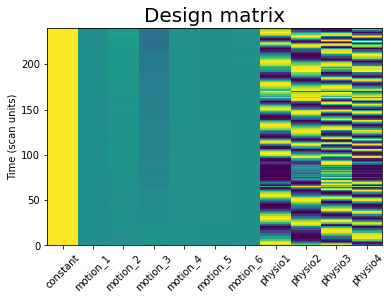

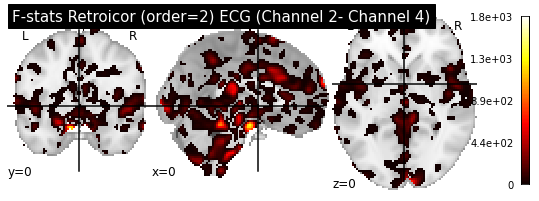

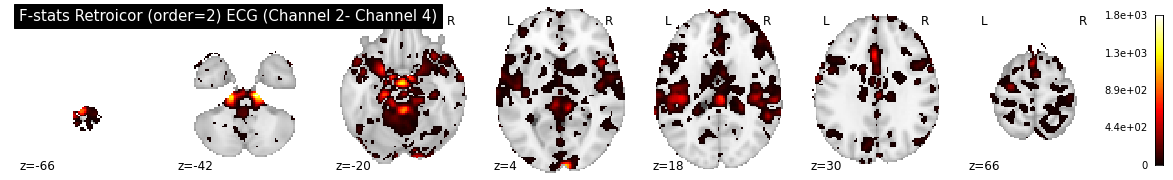

In [5]:
retro_ecg = RetroicorPhysio(physio_rate=400, 
                            t_r=repetition_time, 
                            delta=200, 
                            filtering="butter",
                            high_pass=0.5, 
                            low_pass=3.0, 
                            order=2, 
                            columns=[0,1,0,-1])
ecg_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, ecg_regressors)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["physio1", "physio2", "physio3", "physio4"])

fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

# Fit model
first_level.fit(bold_img, design_matrices=dm)

# Compute contrasts
res_dict = first_level.compute_contrast("physio1+physio2+physio3+physio4", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor (order=2) ECG (Channel 2- Channel 4)")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       display_mode="z", title="F-stats Retroicor (order=2) ECG (Channel 2- Channel 4)")

We can also use fewer or more orders in the retroicor algorithm

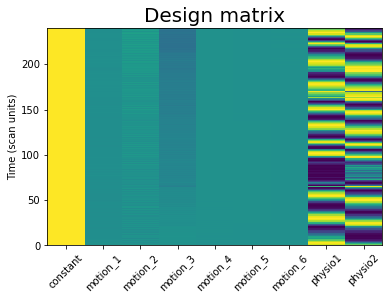

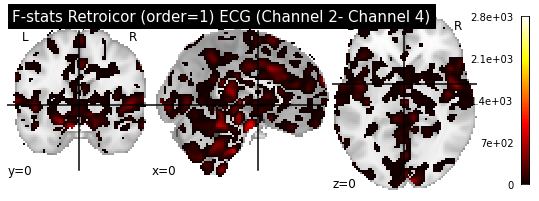

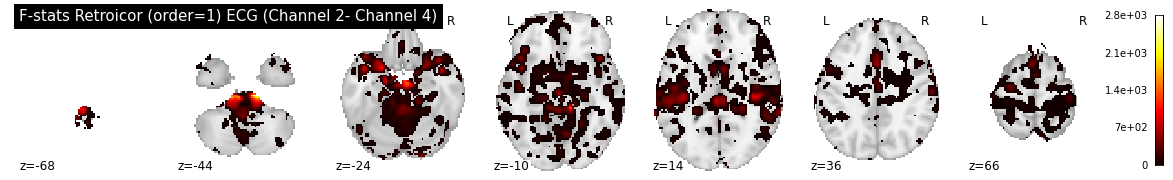

In [6]:
retro_ecg = RetroicorPhysio(physio_rate=400, 
                            t_r=repetition_time, 
                            delta=200, 
                            filtering="butter",
                            high_pass=0.5, 
                            low_pass=3.0, order=1, 
                            columns=[0,1,0,-1])
ecg_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, ecg_regressors)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["physio1", "physio2"])

fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

# Fit model
first_level.fit(bold_img, design_matrices=dm)

# Compute contrasts
res_dict = first_level.compute_contrast("physio1+physio2", stat_type="F", output_type="all")
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor (order=1) ECG (Channel 2- Channel 4)")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       display_mode="z", title="F-stats Retroicor (order=1) ECG (Channel 2- Channel 4)")

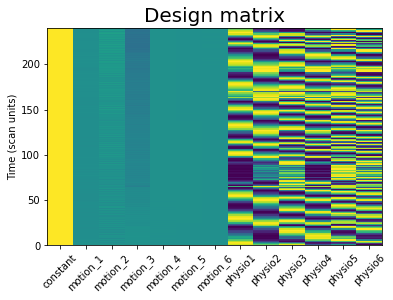

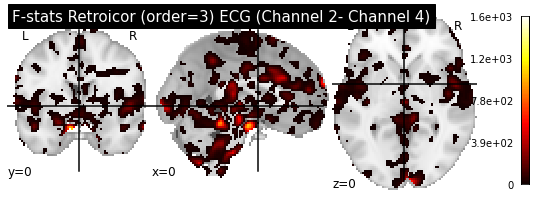

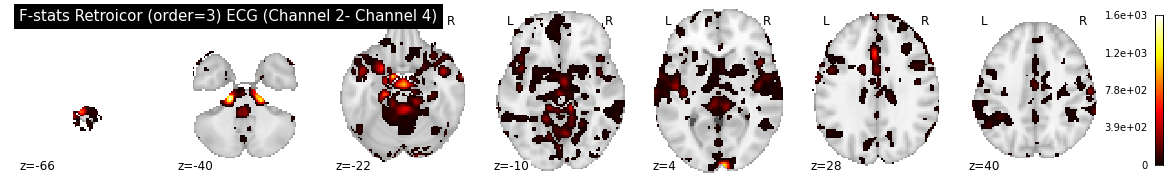

In [7]:
retro_ecg = RetroicorPhysio(physio_rate=400, 
                            t_r=repetition_time, 
                            delta=200, 
                            filtering="butter",
                            high_pass=0.5, 
                            low_pass=3.0, order=3, 
                            columns=[0,1,0,-1])
ecg_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, ecg_regressors)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["physio1", "physio2", "physio3", "physio4", "physio5", "physio6"])

fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

# Fit model
first_level.fit(bold_img, design_matrices=dm)

# Compute contrasts
res_dict = first_level.compute_contrast("physio1+physio2+physio3+physio4+physio5+physio6", stat_type="F", output_type="all")


plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor (order=3) ECG (Channel 2- Channel 4)")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       display_mode="z", title="F-stats Retroicor (order=3) ECG (Channel 2- Channel 4)")

Let's now add also the respiration belt

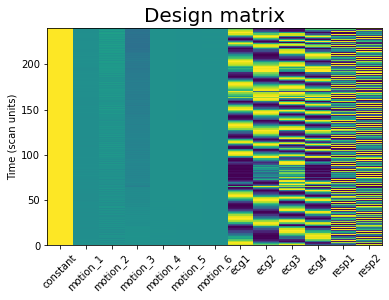

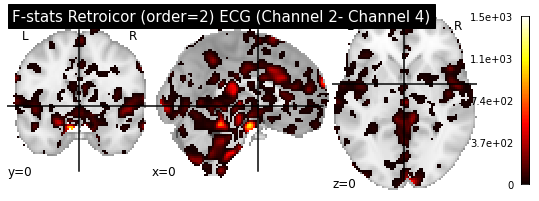

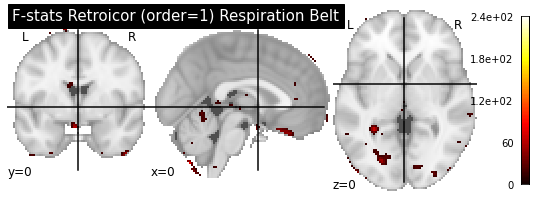

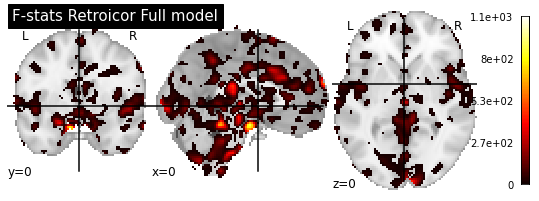

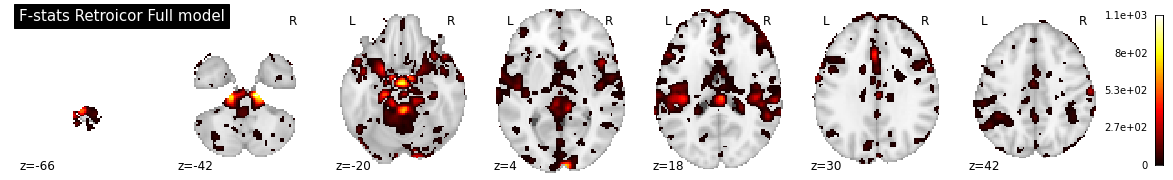

In [8]:
retro_ecg = RetroicorPhysio(physio_rate=400, 
                            t_r=repetition_time, 
                            delta=200, 
                            filtering="butter",
                            high_pass=0.5, 
                            low_pass=3.0, order=2, 
                            columns=[0,1,0,-1])
ecg_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

retro_resp = RetroicorPhysio(physio_rate=400, 
                             t_r=repetition_time, 
                             delta=200, 
                             filtering=None, order=1)
resp_regressors = retro_resp.compute_regressors(signal=resp_signal, time_scan=frame_times)

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, ecg_regressors,  resp_regressors)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["ecg1", "ecg2", "ecg3", "ecg4", "resp1", "resp2"])

fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

# Fit model
first_level.fit(bold_img, design_matrices=dm)

# Compute contrasts
res_dict = first_level.compute_contrast("ecg1+ecg2+ecg3+ecg4", stat_type="F", output_type="all")
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor (order=2) ECG (Channel 2- Channel 4)")


res_dict = first_level.compute_contrast("resp1+resp2", stat_type="F", output_type="all")
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor (order=1) Respiration Belt")

res_dict = first_level.compute_contrast("ecg1+ecg2+ecg3+ecg4+resp1+resp2", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor Full model")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", img1=res_dict['stat'], img2=res_dict['p_value']), 
                       display_mode="z", title="F-stats Retroicor Full model")

## Compare this with using the signal in white matter and csf...

In [9]:
confounders.columns

Index(['csf', 'white_matter', 'global_signal', 'std_dvars', 'dvars',
       'framewise_displacement', 't_comp_cor_00', 't_comp_cor_01',
       't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05',
       'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
       'a_comp_cor_04', 'a_comp_cor_05', 'cosine00', 'cosine01', 'cosine02',
       'cosine03', 'cosine04', 'cosine05', 'non_steady_state_outlier00',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'],
      dtype='object')

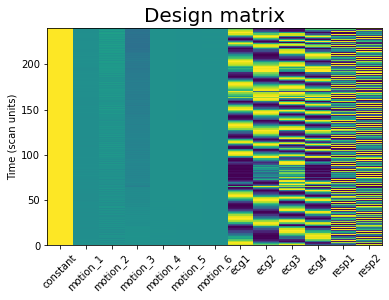

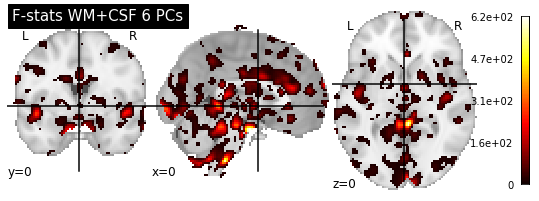

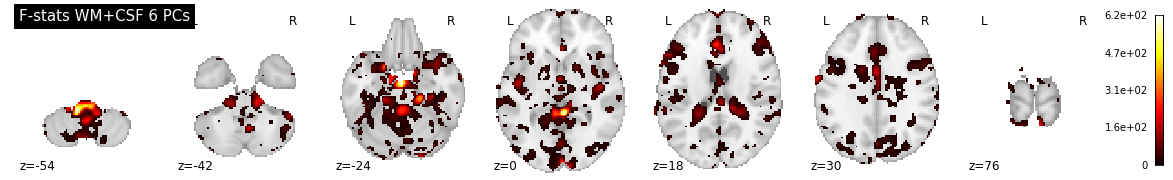

In [10]:
# Contruct new design matrix
acompcor_regs = confounders.filter(regex="a_comp_cor")
dm_acompcor = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, acompcor_regs)), 
                           columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                           ["pc1", "pc2", "pc3", "pc4", "pc5", "pc6"])
dm_acompcor.head()


fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
first_level.fit(bold_img, design_matrices=dm_acompcor)
res_dict_acompcor = first_level.compute_contrast("pc1+pc2+pc3+pc4+pc5+pc6", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_dict_acompcor['stat'], 
                                img2=res_dict_acompcor['p_value']), 
                       cut_coords=(0,0,0), title="F-stats WM+CSF 6 PCs")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_dict_acompcor['stat'], 
                                img2=res_dict_acompcor['p_value']), 
                       display_mode="z", title="F-stats WM+CSF 6 PCs")

# Variation Models

We follow here the same setup as in Verstynen 2011, that is, compute variations in breathing rate/volume to the respiratory signal and the low-pass filtered pulse signal, and variations in heart rate to ECG and high-pass filtered pulse.

In [11]:
rvphysio_resp = RVPhysio(physio_rate=400, t_r=repetition_time)
rv_resp_regressors = rvphysio_resp.compute_regressors(resp_signal, time_scan=frame_times)

# low pass will 400 ms, as in Verstynen2011
rvphysio_puls = RVPhysio(physio_rate=400, t_r=repetition_time, filtering="gaussian", low_pass=1/0.4) 
rv_puls_regressors = rvphysio_puls.compute_regressors(puls_signal, time_scan=frame_times)

hvphysio_ecg = HVPhysio(physio_rate=400, t_r=repetition_time, 
                        filtering="butter", 
                        delta=200, high_pass=0.5, 
                        low_pass=3.0, columns=[0,1,0,-1])
hv_ecg_regressors = hvphysio_ecg.compute_regressors(ecg_signal, time_scan=frame_times)

hvphysio_puls = HVPhysio(physio_rate=400, t_r=repetition_time, filtering="butter", delta=200, high_pass=0.5, 
                            low_pass=3.0)
hv_puls_regressors = hvphysio_puls.compute_regressors(puls_signal, time_scan=frame_times)

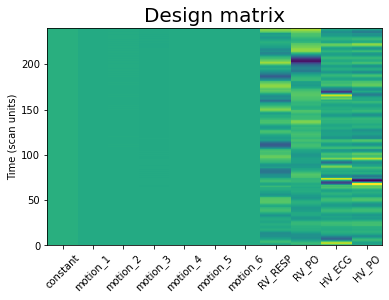

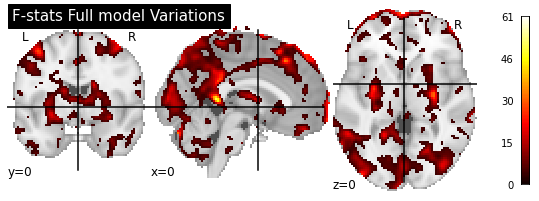

In [12]:
dm_variations = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, 
                                              rv_resp_regressors, rv_puls_regressors,
                                              hv_ecg_regressors, hv_puls_regressors)), 
                           columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                           ["RV_RESP", "RV_PO", "HV_ECG", "HV_PO"])

fig, ax = plt.subplots()
ax.pcolormesh(dm_variations)
ax.set_xticks(np.arange(dm_variations.shape[1])+0.5)
ax.set_xticklabels(dm_variations.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)

first_level.fit(bold_img, design_matrices=dm_variations)
res_dict_acompcor = first_level.compute_contrast("RV_RESP+RV_PO+HV_ECG+HV_PO", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.05)", 
                                img1=res_dict_acompcor['stat'], 
                                img2=res_dict_acompcor['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Full model Variations")

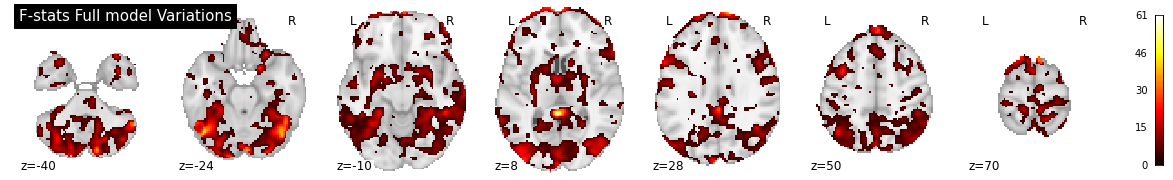

In [13]:
plotting.plot_stat_map(math_img("img1*(img2<0.05)", 
                                img1=res_dict_acompcor['stat'], 
                                img2=res_dict_acompcor['p_value']), 
                       display_mode="z", title="F-stats Full model Variations")

# Downsample models

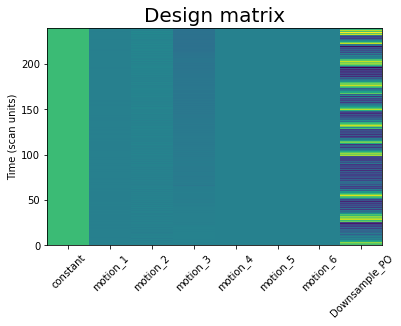

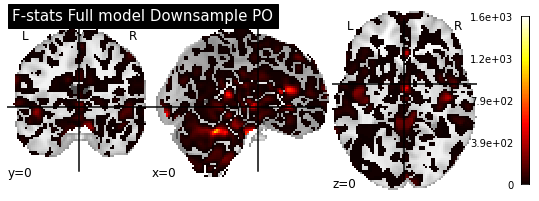

In [14]:
# The inout values are extracted from PhLem example
downsample_puls = DownsamplePhysio(physio_rate=400, 
                                   t_r=repetition_time, 
                                   filtering="butter", 
                                   low_pass=6, 
                                   high_pass=0.1, 
                                   transform="zscore")
downsample_regressors = downsample_puls.compute_regressors(puls_signal, time_scan=frame_times)

dm_downsample = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, downsample_regressors)), 
                           columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                           ["Downsample_PO"])

fig, ax = plt.subplots()
ax.pcolormesh(dm_downsample)
ax.set_xticks(np.arange(dm_downsample.shape[1])+0.5)
ax.set_xticklabels(dm_downsample.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)

first_level.fit(bold_img, design_matrices=dm_downsample)
res_dict_downsample = first_level.compute_contrast("Downsample_PO", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.05)", 
                                img1=res_dict_downsample['stat'], 
                                img2=res_dict_downsample['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Full model Downsample PO")

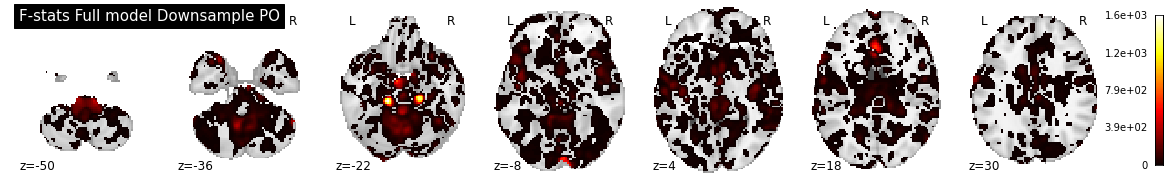

In [15]:
plotting.plot_stat_map(math_img("img1*(img2<0.05)", 
                                img1=res_dict_downsample['stat'], 
                                img2=res_dict_downsample['p_value']), 
                       display_mode="z", title="F-stats Full model Downsample PO")